In [1]:
import pandas as pd
import json
import os, glob
from tqdm import tqdm
dataset = []


# Apply labels to self-supervised set for detectron2 #

In [2]:
import pandas as pd
df = pd.read_parquet('/data/yelena/oct-semisup/data/dfselfsup.parquet',engine='fastparquet')
# dfspecial = df[df.age==90.0100].groupby(['ptid','eye'])['instance'].count().sort_values(ascending=False)
# dfspecial[dfspecial>1]
df = df[df.age<90.0100] #max age == lots of cross-talk between labels, exclude
df = df.drop(columns=['slicei','fpath'])
df = df.loc[df.astype(str).drop_duplicates().index]
#merge on dx labels
dflabels = pd.read_parquet('/data/yelena/oct-semisup/data/dflabels_v2_procedure.parquet',engine='fastparquet')
dflabels = dflabels.fillna('NA')

In [3]:
#eyes after injection to exclude
inj_eye = dflabels[dflabels['PROC_CODE']== '67028'][['ptid','eye','age']].drop_duplicates()
inj_eye = inj_eye.groupby(['ptid','eye']).min()

dfexclude = dflabels.merge(inj_eye,on=['ptid','eye'],suffixes=['','_inj']).query('age>=age_inj').drop('age_inj',axis=1)[['ptid','eye','age']].drop_duplicates()
dflabels = dflabels[['ptid','eye','age','diagnosis']].groupby(['ptid','eye','age']).aggregate(lambda dx: dx.unique().tolist())
df = df.merge(dflabels,how='left', on=['ptid','eye','age']) #this assumes dx is a list
#exclude eyes after they've received injection
df = df.merge(dfexclude,how='left',on=['ptid','eye','age'],indicator=True).query('_merge=="left_only"').drop('_merge',axis=1)
#select AMD dx
df = df[df.diagnosis.apply(lambda x: 'AMD' in x)]
#exclude all dx other than AMD, glaucoma, PVD, hypertensive retinopathy
ind = df.diagnosis.apply(lambda x: len(set(x).intersection(set(['central serous chorioretinopathy',
       'Macular pucker', 
       'Diabetic Eye Disease', 
       'Potentially abnormal', 'Uveitis', 'Inherited Retinal Disease',
       'Retinal Vascular Occlusion', 'Macular Hole', 'Retinal edema',
       'Retinal Detachment', 'Vitreomacular Adhesion',
       'Retinal Vasculitis', 'Vitreous hemorrhage'])))>0)
df = df[~ind]
df.astype(str).nunique()

ptid         1154
eye             2
age          3225
instance     5977
diagnosis      15
dtype: int64

In [4]:
#merge on logmar
dfva = pd.read_csv('/data/tspaide/ybdino/data/oct_logmars.csv',index_col=0)
df = df.merge(dfva[['instance','logmar']],how='inner',on='instance')
#filter 20/40 or better
df = df[df.logmar<=.3]
df.astype(str).nunique()

ptid          912
eye             2
age          2436
instance     4002
diagnosis      14
logmar          5
dtype: int64

In [5]:
#sample 1 volume per ptid
dfsample = df.sample(frac=1,random_state=4).drop_duplicates(subset=['ptid'],keep='first')

In [6]:
dfsample.assign(fold='semisup_AMD_preinj_sample').to_parquet('/data/amd-data/cera-rpd/detectron2-rpd/datasets/dfUWAMD_dfsemisup_preinj_sample.parquet')

In [ ]:
#find high frequency volumes for longitudnal study
dfcnt = df.groupby(['ptid','eye'])['instance'].count()
ptid= dfcnt[dfcnt>20].reset_index().ptid
df = df[df.ptid.isin(ptid)]
df.astype(str).nunique()
#df.assign(fold='semisup_AMD_long_preinj').to_parquet('/data/amd-data/cera-rpd/detectron2-rpd/datasets/dfUWAMD_dfsemisup_long_preinj.parquet')

# Read in dataframe of interest

In [ ]:
df = pd.read_parquet('dfUWAMD_eval_train_v2_classify.parquet')
df = df.drop(columns = ['slicei','img_path'])
df = df.loc[df.astype(str).drop_duplicates().index]
df.columns


In [2]:
df = pd.read_parquet('dfUWAMD_dfsemisup_long.parquet')
df.columns

Index(['ptid', 'eye', 'age', 'instance', 'diagnosis', 'logmar', 'fold'], dtype='object')

In [7]:
df = pd.read_parquet('/data/amd-data/cera-rpd/detectron2-rpd/datasets/dfUWAMD_dfsemisup_preinj_sample.parquet')
df.shape

(912, 7)

In [8]:
(df.diagnosis.apply(lambda x: len(x))==1).sum()

520

In [9]:
df.diagnosis

index
2087                         [Glaucoma, AMD]
1105                         [Glaucoma, AMD]
21                           [AMD, Glaucoma]
4992                                   [AMD]
3606    [Posterior Vitreous Detachment, AMD]
                        ...                 
3392                                   [AMD]
276                          [AMD, Glaucoma]
837                                    [AMD]
5183                         [AMD, Glaucoma]
2203                                   [AMD]
Name: diagnosis, Length: 912, dtype: object

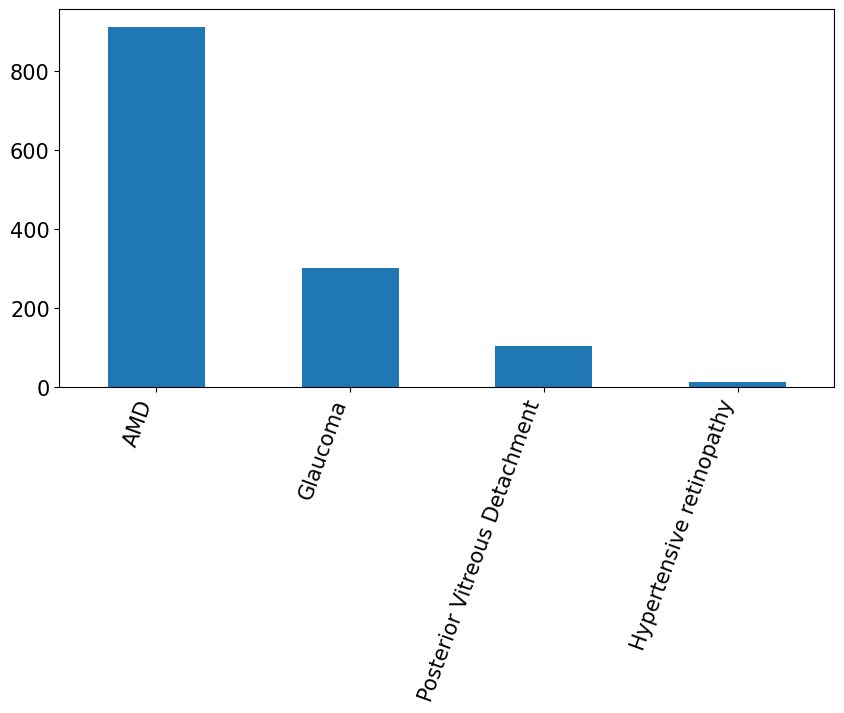

In [13]:
import matplotlib.pyplot as plt
plt.style.use('../ybpres.mplstyle')
fig,ax = plt.subplots(1,1,dpi=100,figsize=[10,5])
df.diagnosis.explode().value_counts().plot(kind='bar',rot=70,log=False)
plt.xticks(ha="right");

In [14]:

#dfmap = pd.DataFame(columns=['instance','referenceID'])
rootdir = '/data/oct-heyex-data/macoct/'
for ptid in tqdm(df.ptid.unique()): #for each ptid
    path = os.path.join(rootdir,ptid,'macOCT','*','oct.json')
    paths = glob.glob(path)
    for p in paths: #for each instance/eye volume
        d = json.load(open(p))
        dataset.append(d)


100%|██████████| 912/912 [00:06<00:00, 147.41it/s]


In [15]:
dfmap = pd.DataFrame(dataset)
dfmap.columns

Index(['ptid', 'study', 'series', 'age', 'laterality', 'instance', 'thickness',
       'res1', 'res2', 'type', 'octh', 'referenceID', 'volshape'],
      dtype='object')

In [16]:
dfa = df.merge(dfmap[['instance','referenceID','volshape','octh','res2','thickness']],on=['instance'])
dfa = dfa.assign(slicei =dfa.apply(lambda x: list(range(x.volshape[0])),axis=1)).explode(['octh','slicei'])
dfa = dfa.assign(img_path=dfa.apply(lambda x: os.path.join(rootdir,x.ptid,'macOCT',x.referenceID,'oct-{:03d}.png'.format(x.slicei)),axis=1))
#dfa = dfa.assign(fold = 'dfeval_train_v2')
dfa = dfa.assign(msk_path = '')
dfa = dfa.reset_index(drop=True)
dfa.columns


Index(['ptid', 'eye', 'age', 'instance', 'diagnosis', 'logmar', 'fold',
       'referenceID', 'volshape', 'octh', 'res2', 'thickness', 'slicei',
       'img_path', 'msk_path'],
      dtype='object')

In [17]:
pd.set_option('display.max_colwidth',1000)
dfa.loc[:,'ir_path'] = dfa['img_path'].str.replace('oct-....png','ir.png',regex=True)


In [18]:
dfa.to_parquet('/data/amd-data/cera-rpd/detectron2-rpd/datasets/dfUWAMD_dfsemisup_preinj_sample_toserve.parquet')


In [19]:
dfa[['ptid', 'eye', 'instance', 'slicei','volshape']].astype('str').nunique()

ptid        912
eye           2
instance    912
slicei       61
volshape      1
dtype: int64

## Assigning folds (for large datasets)

In [41]:
from sklearn.model_selection import GroupKFold
splitter = GroupKFold(n_splits=10)
splits = splitter.split(dfa,None,groups=dfa.ptid)

In [42]:
#Check intersection
setlist = []
for i, (_, idx) in enumerate(splits):
    setlist.append(set(dfa.loc[idx]['ptid']))
    dfa.loc[idx,'fold'] = 'fold{}'.format(i+1)
print(set.intersection(*setlist))


set()


In [52]:
dfa[dfa.fold=='fold1'][['ptid','eye','age']].drop_duplicates().groupby(['ptid','eye']).count()

age
ptid                                               eye     
055bdc3ae92212dd5daa3a66358d58283ce6e60dc8c8d9f... L     56
                                                   R     53
251a1bd5290c932d6cc30975aa8806f8318285286c450c6... L     31
                                                   R     32
312b99fe94469e7deb6e5d495723b0b2710560ed4ac0fae... L     20
                                                   R     21
451a0840d96f0270eff6f77ea28de9d08f7c38ce5102a73... L     26
                                                   R     28
6c9b0ab7f453360f55632b4ce94e21e13a683e35388572e... L     25
                                                   R     24
785e3d83e3884be99059c27eb9281741f8cda04620311b2... L     30
8372fdd11a12708c81d60a17da5a4dc8515f89007a526a3... L     34
                                                   R     33
a11344503550b58ab75a62be10976e44699a71a89c60aac... L     16
                                                   R     15
f79399dcc307dff6e327a2fc6cbbf03183154413643fb8a... R     23

In [44]:
dfa.to_parquet('dfsemisup_long_refined.parquet')

In [46]:
from data import rpd_data
import pickle

data = rpd_data(dfa.rename(columns={'instance':'volID'}),grp='fold1',data_has_ann=False)
pickle.dump(data, open("dfsemisup_long_fold1.pk", "wb"))

29585it [02:35, 190.02it/s]


Found 29585 images
Found 0 instances
Found 0 too few vertices


In [49]:
dat = pickle.load(open('dfsemisup_long_fold1.pk','rb'))
len(dat)

603.7755102040817